# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. If your data is in counts format, consider first transforming to log2(cpm+1) with edgeR.

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

# Begin miner analysis

## Import standard dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner
%matplotlib inline
plt.style.use('ggplot')

## Create directory to save output files

In [2]:
# Path to the miner directory
proj_path = os.path.join(os.path.expanduser('~'),'Projects','miner3')
input_path = os.path.join(proj_path, 'miner_mindata')

# create name for results folder where output files will be saved
resultsFolder = "miner_network_results"

# create results directory
resultsDirectory = os.path.join(proj_path,resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load reference dictionary for mechanistic inference (skip if using default)

In [3]:
# #provide absolute path to your .csv-format reference database
# filename = os.path.join(os.path.split(os.getcwd())[0],"data","reference_database_example.csv")
# #provide absolute path to the miner/data/network_dictionaries directory where your database will be stored
# network_dictionaries_path = os.path.join(os.path.split(os.getcwd())[0],"data","network_dictionaries")
# #name your reference database and use the extension ".pkl"
# dictionaryName = "reference_database.pkl"
# #import and save your reference database to the Python pickle format for future use
# reference_mechanistic_database = miner.fileToReferenceDictionary(filename,os.path.join(network_dictionaries_path,dictionaryName))

## 0. Load and pre-process data; set parameters

In [4]:
# Load expression Data
expressionFile = os.path.join(input_path,"expression","IA12Zscore.csv")
id_names = os.path.join(input_path, "identifier_mappings.txt")
expressionData, conversionTable = miner.preprocess(expressionFile, id_names)

completed identifier conversion.
16216 genes were converted. 10285 genes were dropped due to identifier mismatch


Text(0.5, 0, 'Relative expression')

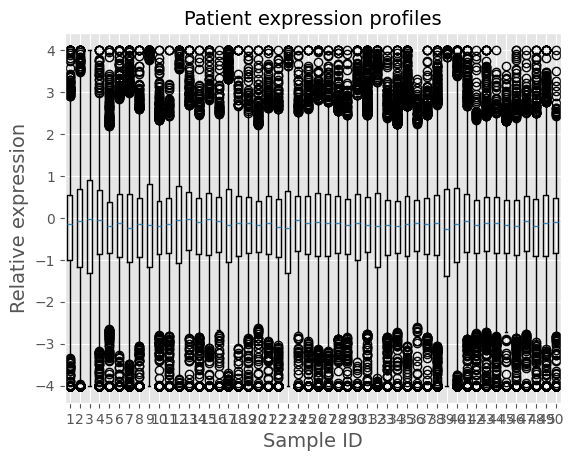

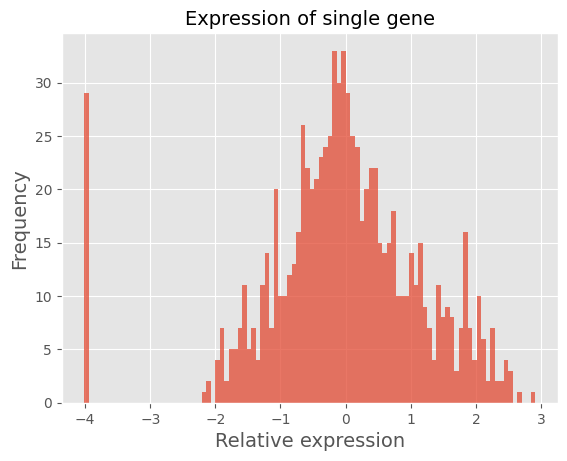

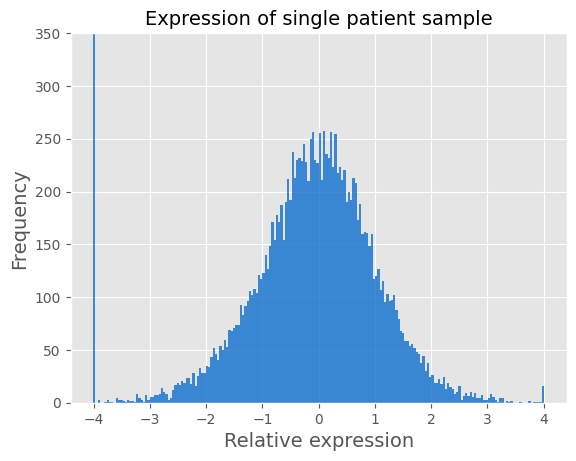

In [5]:
# Visualize pre-processed expression data
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",fontsize=14)
plt.ylabel("Relative expression", fontsize=14)
plt.xlabel("Sample ID", fontsize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Relative expression", fontsize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Relative expression", fontsize=14)

## Set parameters

In [6]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb2_tf_to_genes.pkl" #default option
database_path = os.path.join(proj_path, 'miner', 'data', 'network_dictionaries', mechanistic_database)
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 5

# 1. Co-expression clustering

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 40.74 minutes
Completed coexpression clustering in 40.77 minutes
Number of genes clustered: 4883
Number of unique clusters: 81
Completed clustering module in 40.77 minutes


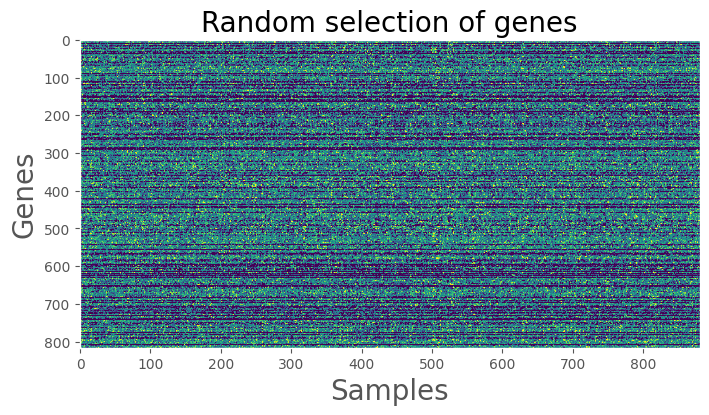

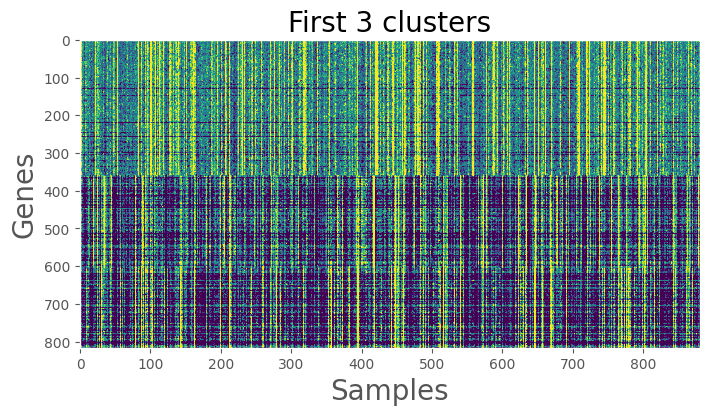

In [7]:
# Network inference may take several minutes. 
# Prompts will print at 0, 20, 40, 60, 80, and 100% complete

t1 = time.time() 
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=17,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
t2 = time.time()
print("Completed coexpression clustering in {:.2f} minutes".format((t2-t1)/60.))

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(
    expressionData.index,len(first_clusters),
    replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes", fontsize=20)
plt.xlabel("Samples", fontsize=20)
plt.title("Random selection of genes", fontsize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes", fontsize=20)
plt.xlabel("Samples", fontsize=20)
plt.title("First 3 clusters", fontsize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t3 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t3-t1)/60.))

# 2. Mechanistic inference

In [8]:
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,
                                               correlationThreshold=minCorrelation,numCores=numCores,
                                               database_path=database_path)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
# Get eigengenes for all modules
eigengenes = miner.getEigengenes(regulonModules,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)
#write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference
READING TFBS2GENES:  /Users/weiju/Projects/miner3/miner/data/network_dictionaries/tfbsdb2_tf_to_genes.pkl
Completed mechanistic inference in 0.77 minutes
Inferred network with 6964 regulons, 364 regulators, and 2262 co-regulated genes


# 3. Network mapping

In [9]:
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.background_df(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 0.61 minutes


Text(0.5, 0, 'Samples')

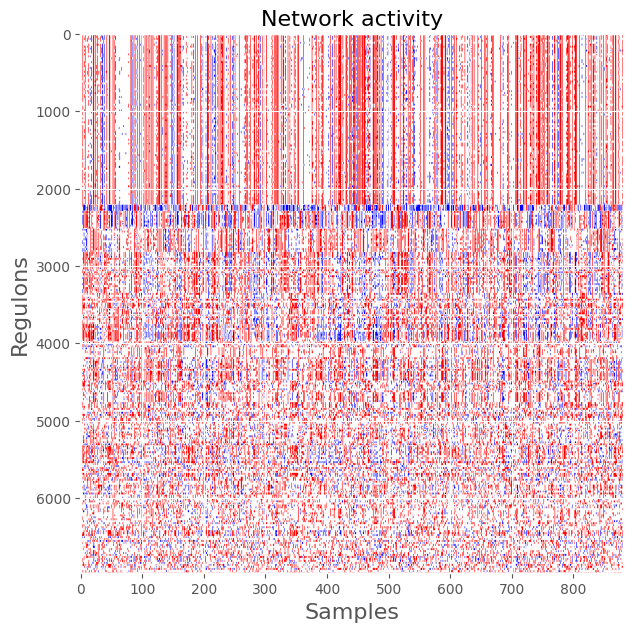

In [10]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity", fontsize=16)
plt.ylabel("Regulons", fontsize=16)
plt.xlabel("Samples", fontsize=16)

# 4. Expand regulons (optional, not default)

In [11]:
t1 = time.time()
tfbsdbGenes_file = os.path.join(input_path, "network_dictionaries","tfbsdb_genes_to_tf.pkl")
expandedRegulons = miner.parallelRegulonExpansion(eigengenes,regulonModules,regulonDf,
                                                  expressionData,tfbsdbGenes_file,
                                                  overExpressedMembersMatrix,
                                                  corrThreshold = 0.25,auc_threshold = 0.70,
                                                  numCores=5)

regulonIDtoRegulator = miner.regulonIdToRegulator(regulonDf)
expandedRegulonDf = miner.regulonDictToDf(expandedRegulons,regulonIDtoRegulator)
t2 = time.time()
print("Completed regulon expansion in {:.2f} minutes".format((t2-t1)/float(60.)))

expandedEigengenes = miner.getEigengenes(expandedRegulons,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(expandedEigengenes,95)
expandedEigengenes = eigenScale*expandedEigengenes
expandedEigengenes.index = np.array(expandedEigengenes.index).astype(str)

Completed 0 of 3070 iterations
Completed 1000 of 3070 iterations
Completed 2000 of 3070 iterations
Completed 3000 of 3070 iterations
Completed 0 of 3070 iterations
Completed 1000 of 3070 iterations
Completed 2000 of 3070 iterations
Completed 3000 of 3070 iterations
Completed 0 of 3069 iterations
Completed 1000 of 3069 iterations
Completed 2000 of 3069 iterations
Completed 3000 of 3069 iterations
Completed 0 of 3070 iterations
Completed 1000 of 3070 iterations
Completed 2000 of 3070 iterations
Completed 3000 of 3070 iterations
Completed 0 of 3070 iterations
Completed 1000 of 3070 iterations
Completed 2000 of 3070 iterations
Completed 3000 of 3070 iterations
Completed regulon expansion in 11.29 minutes


In [12]:
expandedEigengenes.to_csv(os.path.join(resultsDirectory,"expanded_eigengenes.csv"))
expandedRegulonDf.to_csv(os.path.join(resultsDirectory,"expanded_regulonDf.csv"))
miner.write_json(expandedRegulons,os.path.join(resultsDirectory,"expanded_regulons.json"))
print("Expanded network to {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(expandedRegulonDf.Regulon_ID.unique()),
                                                                                                 len(expandedRegulonDf.Regulator.unique()),
                                                                                                 len(expandedRegulonDf.Gene.unique())))

Expanded network to 6964 regulons, 364 regulators, and 3413 co-regulated genes


# 5. Causal inference

In [13]:
# Load mutation matrices
common_mutations_file = os.path.join(input_path,"mutations","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(input_path,"mutations","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(input_path,"mutations","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [14]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes

miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

Creating directories if dont exist
Testing correlation of TF and cluster eigengene.
Looping through each mutation
completed causal analysis in 0.89 minutes
Creating directories if dont exist
Testing correlation of TF and cluster eigengene.
Looping through each mutation
completed causal analysis in 0.30 minutes
Creating directories if dont exist
Testing correlation of TF and cluster eigengene.
Looping through each mutation
completed causal analysis in 0.29 minutes


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned,Fraction_of_aligned_and_diff_exp_edges,number_downstream_regulons,number_differentially_expressed_regulons
6639,TRAF3,ENSG00000043039,R-6639,-1.0,4.196775,-0.158437,2.291286e-06,2.018640,1.322503,1.0,1.0,1,1
4906,TRAF3,ENSG00000160685,R-4906,1.0,2.229744,-0.350746,6.680532e-27,-3.282541,2.793781,1.0,1.0,1,1
3802,TRAF3,ENSG00000151702,R-3802,-1.0,5.058294,0.687376,3.267725e-124,-4.984390,5.401263,1.0,1.0,25,25
3808,TRAF3,ENSG00000151702,R-3808,-1.0,5.058294,0.687376,3.267725e-124,-4.984390,5.401263,1.0,1.0,25,25
3806,TRAF3,ENSG00000151702,R-3806,-1.0,5.058294,0.687376,3.267725e-124,-4.984390,5.401263,1.0,1.0,25,25


In [15]:
# filtered causal results
causal_results_regulon_filtered = causal_results[causal_results["-log10(p)_Regulon_stratification"]>=-np.log10(0.05)]
causal_results_aligned = causal_results_regulon_filtered[causal_results_regulon_filtered.Fraction_of_edges_correctly_aligned>=0.5]
causal_results_aligned_correlated = causal_results_aligned[causal_results_aligned["RegulatorRegulon_Spearman_p-value"]<=0.05]
causal_results_stratified_aligned_correlated = causal_results_aligned_correlated[causal_results_aligned_correlated["-log10(p)_MutationRegulatorEdge"]>=-np.log10(0.05)]

# for all causal flows, 
# the regulon is differentially active w.r.t the mutation,
# the regulator is differentially active w.r.t the mutation,
# the regulator is significantly correlated to the regulon,
# and the directionality of at least half of the differentially active targets 
# downstream of the regulator are consistent with the perturbation from the mutation

causal_results_stratified_aligned_correlated.to_csv(os.path.join(resultsDirectory,"filteredCausalResults.csv"))

# 6. Subtype discovery

In [16]:
# Infer transcriptional states
minClusterSize = int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = int(np.ceil(0.01*expressionData.shape[1])),restricted_index=None)
states_dictionary = {str(i):states[i] for i in range(len(states))}
miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_states.json"))

Beginning subtype inference
completed subtype inference in 0.34 minutes


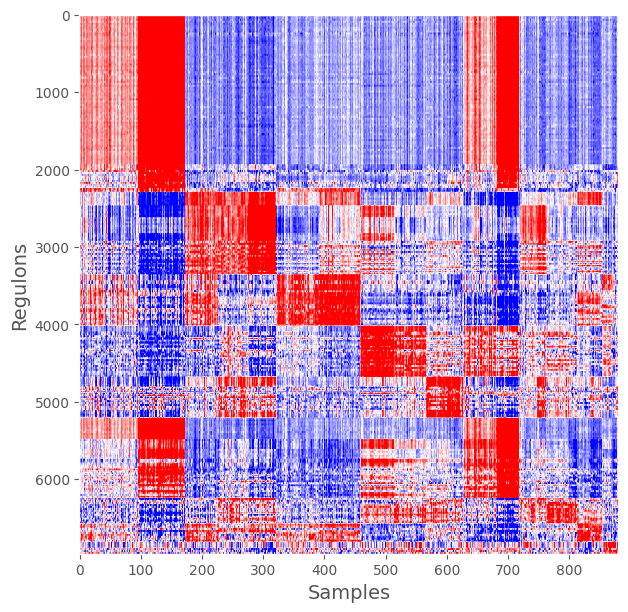

In [17]:
# Infer transcriptional programs
reference_df = eigengenes.copy()
programs, _ = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
programs_dictionary = {str(i):program_list[i] for i in range(len(program_list))}
miner.write_json(programs_dictionary,os.path.join(resultsDirectory,"transcriptional_programs.json"))
mosaicDf = reference_df.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

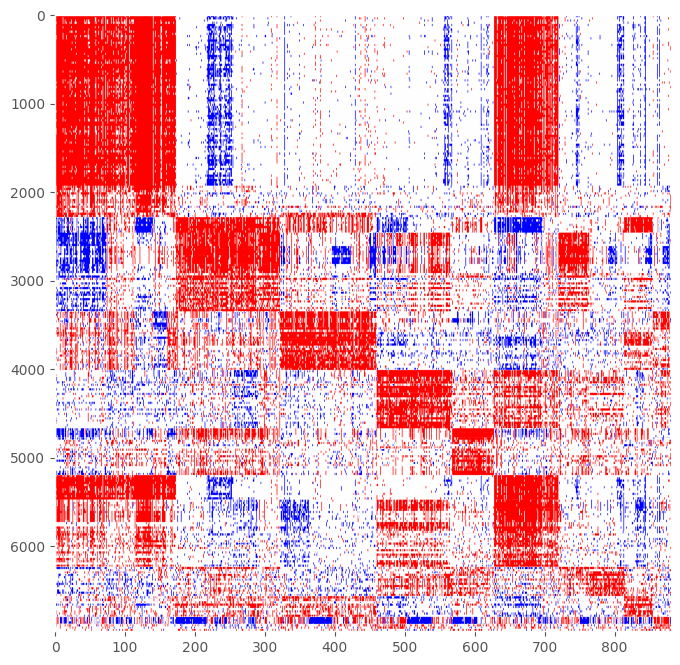

In [18]:
dfr = overExpressedMembersMatrix-underExpressedMembersMatrix
mtrx = dfr.loc[np.hstack(program_list),np.hstack(states)]
plt.figure(figsize=(8,8))
plt.imshow(mtrx,cmap="bwr",vmin=-1,vmax=1,aspect=float(mtrx.shape[1])/float(mtrx.shape[0]))
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"mosaic_all.pdf"),bbox_inches="tight")

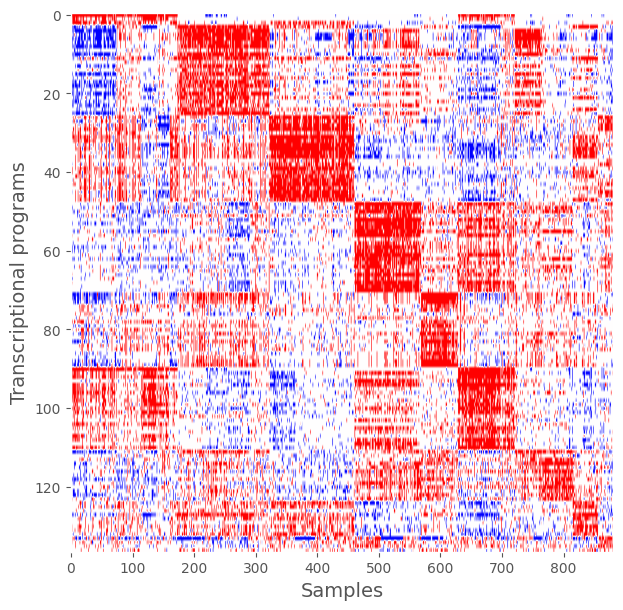

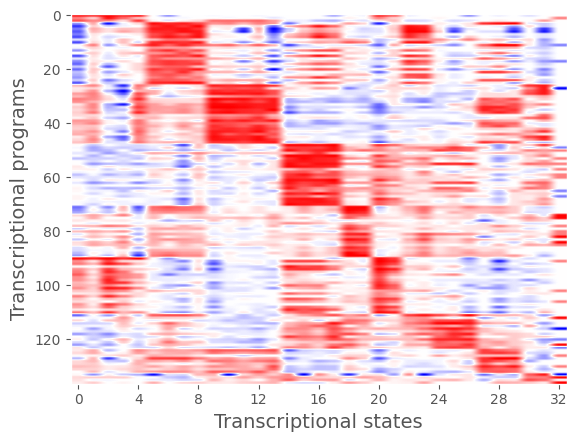

In [19]:
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=dfr.loc[np.hstack(program_list),np.hstack(states)],programs=program_list,states=states,stateThreshold=0.50,saveFile=os.path.join(resultsDirectory,"transcriptional_programs.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"),showplot=True)